In [1]:
## testing for Insulin cases by splitting data into two different sets 
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from statsmodels.formula.api import glm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [7]:
# Load the data into a DataFrame; testinginsulin
df = pd.read_csv('/Users/Tristan/Documents/Projekte/Boston Celi/1 Glucose Likelihood/Glucose-Research/data/cohorted_data.csv')


In [8]:
df.fillna(0, inplace=True)  # Account for NaNs in subset

In [9]:
categorical_vars = ['insurance']
dummy_vars1 = pd.get_dummies(df[categorical_vars])
df = pd.concat([df, dummy_vars1], axis=1)

dummy_vars = dummy_vars1.drop(columns=['insurance_Other'])



In [10]:
#normalized total_glucose_measurements
df['total_glucose_measurements_per_los'] = df['total_glucose_measurements_lab']/df['los']

In [11]:
categorical_vars1 = ['race_group']
dummy_vars = pd.get_dummies(df[categorical_vars1])
race_df = pd.concat([df, dummy_vars], axis=1)
race_df.fillna(0, inplace=True)

Training data set length=17448
Testing data set length=7479
                         Generalized Linear Model Regression Results                          
Dep. Variable:     total_glucose_measurements_per_los   No. Observations:                17448
Model:                                            GLM   Df Residuals:                    17427
Model Family:                        NegativeBinomial   Df Model:                           20
Link Function:                                    Log   Scale:                          1.0000
Method:                                          IRLS   Log-Likelihood:                -35474.
Date:                                Thu, 15 Feb 2024   Deviance:                       2813.3
Time:                                        21:47:54   Pearson chi2:                 3.26e+03
No. Iterations:                                     6   Pseudo R-squ. (CS):            0.07643
Covariance Type:                            nonrobust                                

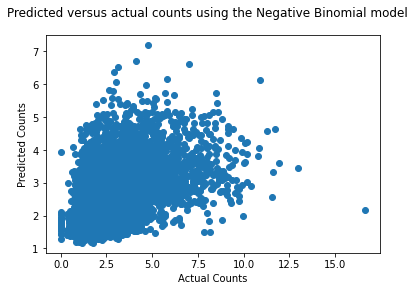

In [16]:

split_index = int(len(race_df) * 0.7)  # 80% for training, 20% for testing

df_train = race_df[:split_index]
df_test = race_df[split_index:]
print('Training data set length=' + str(len(df_train)))
print('Testing data set length=' + str(len(df_test)))

expr = 'total_glucose_measurements_per_los ~ major_surgery + methylprednisolone_equivalent_normalized_by_icu_los + insurance_Medicare + insurance_Medicaid + language + race_group_Asian + race_group_Black + race_group_Hispanic + gender + age + SOFA + charlson_comorbidity_index + admElective + hadInsulinDayOne + anchor_year_group + copd_present + diabetes + asthma_present'
# ask about asthma, confirm insulin, and major_surgery

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

# Creating the Negative Binomial model
nb_training_results = sm.GLM(y_train, X_train, family = sm.families.NegativeBinomial(alpha = 1)).fit()


print(nb_training_results.summary())

# Extract coefficient names and values
coef_names = nb_training_results.params.index
coef_values = nb_training_results.params.values

# Calculate exponentiated coefficients
coef_exp = np.exp(coef_values)
print(coef_exp)

negbin_predictions = nb_training_results.predict(X_test)
predicted_counts = negbin_predictions
actual_counts = y_test['total_glucose_measurements_per_los']

# Calculate RMSE for the negative binomial model
rmse = np.sqrt(np.mean(np.power(predicted_counts - actual_counts, 2)))
print('Negative Binomial RMSE=', rmse)

# Calculate R-squared for count data models
total_var = np.sum(np.power(actual_counts - np.mean(actual_counts), 2))
deviance = np.sum(np.power(actual_counts - predicted_counts, 2))
r2_count = 1 - (deviance / total_var)
print("R-squared (Count Data Models):", r2_count)


#Accuracy of the test set

print("R-square of train set: ", round(r2_score(y_test, predicted_counts)*100, 2), "%")

# Creating and plotting the graph
fig = plt.figure()
fig.suptitle('Predicted versus actual counts using the Negative Binomial model')
plt.scatter(actual_counts, predicted_counts)
plt.xlabel('Actual Counts')
plt.ylabel('Predicted Counts')
#plt.ylim(0,35)
#plt.xlim(0,35)
plt.show()


In [17]:
import numpy as np

# Assuming you have the results from nb_training_results.summary2()
# Replace the following line with the actual summary results from your model
summary_table = nb_training_results.summary2().tables[1]
#summary_table.drop('Intercept', axis=0)

# Extract the CI columns from the summary table and create a copy
coef_table = summary_table[['[0.025', '0.975]']].copy()

variable_names = summary_table.index

# Exponentiate the CI values using np.exp()
LCI_exp = np.exp(coef_table['[0.025'])
UCI_exp = np.exp(coef_table['0.975]'])

# Add the exponentiated CI values to the DataFrame as new columns
coef_table['Lower_CI_exp'] = LCI_exp
coef_table['Upper_CI_exp'] = UCI_exp
coef_table['Variables'] = variable_names

#Inserting exponentiating coefficients
coef_table.insert(0, 'IRR', coef_exp)

# Drop the original non-exponentiated CI columns
coef_table.drop(columns=['[0.025', '0.975]'], inplace=True)


# Round the values in the DataFrame to a specified number of decimal places (e.g., 5)
coef_table = coef_table.round(3)

# Display the table
print(coef_table)

# Download as a CSV file
coef_table.to_csv('IRR2_results.csv', index=False)
#import to numbers; 

                                                      IRR  Lower_CI_exp   
Intercept                                           1.447         1.272  \
insurance_Medicare[T.True]                          0.958         0.919   
insurance_Medicaid[T.True]                          0.936         0.867   
language[T.ENGLISH]                                 1.043         0.971   
race_group_Asian[T.True]                            1.010         0.906   
race_group_Black[T.True]                            0.993         0.937   
race_group_Hispanic[T.True]                         1.019         0.923   
gender[T.M]                                         1.051         1.013   
admElective[T.True]                                 1.363         1.251   
hadInsulinDayOne[T.True]                            1.202         1.156   
anchor_year_group[T.2011 - 2013]                    1.050         1.003   
anchor_year_group[T.2014 - 2016]                    1.058         1.007   
anchor_year_group[T.2017 

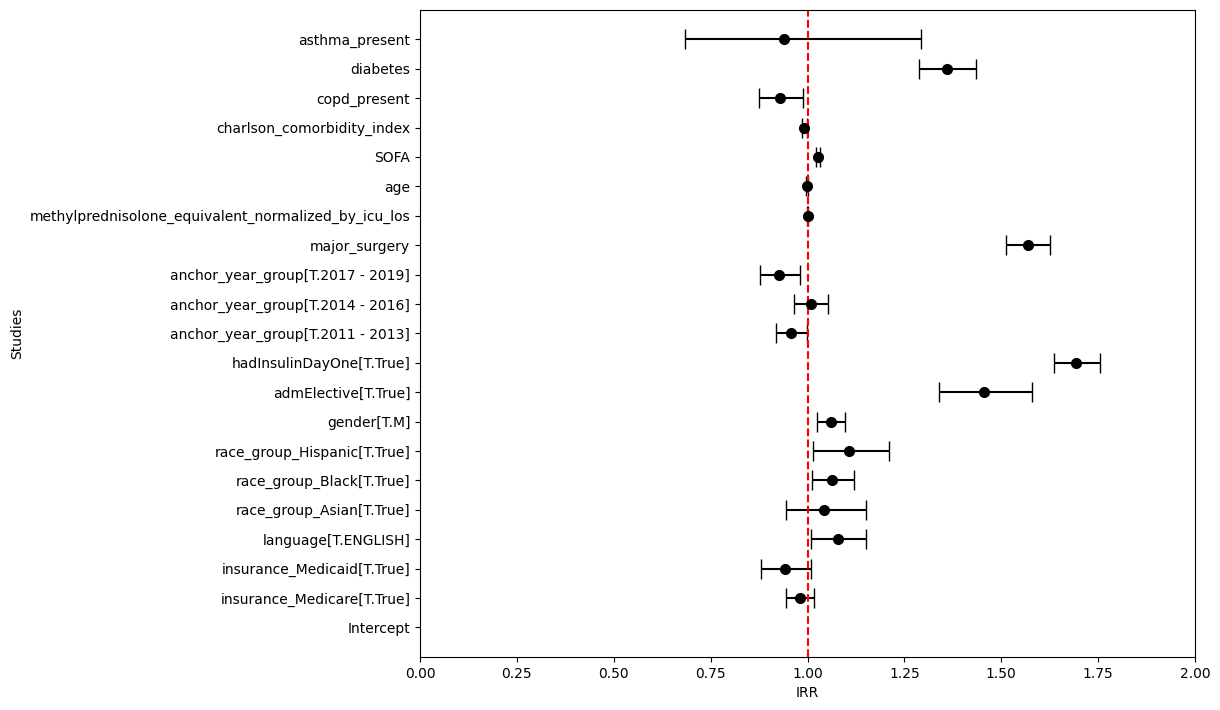

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the DataFrame 'coef_table' with columns: 'IRR', 'Lower_CI_exp', 'Upper_CI_exp'
#coef_table = coef_table.sort_values(by='Upper_CI_exp', ascending=True)

plt.figure(figsize=(10, len(coef_table) * 0.4))  # Adjust the figure size according to your preference

# Calculate the errors for error bars without taking the absolute value
lower_errors = coef_table['IRR'] - coef_table['Lower_CI_exp']
upper_errors = coef_table['Upper_CI_exp'] - coef_table['IRR']

# Create the forest plot with error bars
plt.errorbar(coef_table['IRR'], range(len(coef_table)), xerr=[lower_errors, upper_errors],
             linestyle='', marker='o', markersize=7, capsize=7, color='black')

# Set the y-ticks and labels
plt.yticks(range(len(coef_table)), coef_table.index)
plt.axvline(x=1, color='red', linestyle='--', label='IRR = 1')

# Set the labels for x and y axes
plt.xlabel('IRR')
plt.ylabel('Studies')
plt.xlim(0, 2)

# Show the plot
plt.show()


In [ ]:
def calculate_vif(race_df):
    # Create a DataFrame to store the VIF values
    vif_data = pd.DataFrame()
    vif_data["Feature"] = race_df.columns
    vif_data["VIF"] = [variance_inflation_factor(race_df.values, i) for i in range(race_df.shape[1])]
    return vif_data

# Assuming 'X_train' is a DataFrame containing the predictor variables
vif_result = calculate_vif(X_train)
print(vif_result)


                                              Feature        VIF
0                                           Intercept  52.837563
1                          insurance_Medicare[T.True]   1.316184
2                          insurance_Medicaid[T.True]   1.139893
3                                 language[T.ENGLISH]   1.370369
4                            race_group_Asian[T.True]   1.164051
5                            race_group_Black[T.True]   1.064405
6                         race_group_Hispanic[T.True]   1.253407
7                                         gender[T.M]   1.029979
8                                 admElective[T.True]   1.057054
9                            hadInsulinDayOne[T.True]   1.139553
10                   anchor_year_group[T.2011 - 2013]   1.216876
11                   anchor_year_group[T.2014 - 2016]   1.250495
12                   anchor_year_group[T.2017 - 2019]   1.282694
13                                      major_surgery   1.171470
14  methylprednisolone_eq